In [87]:
import warnings
warnings.filterwarnings('ignore')
import tqdm as tqdm
import random
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("default")
import seaborn as sns
sns.color_palette("coolwarm", as_cmap=True)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [88]:
category = pd.read_csv('./data/KOSPI_업종.csv', encoding='cp949')
kospi200 = pd.read_csv('./data/KOSPI_200Data.csv')

In [89]:
category.columns = ['종목코드', 'name', '시장구분', '업종명', '종가', '대비', '등락률', '시가총액']
category = category[['name', '업종명']]

df = kospi200.merge(category, how='left', on='name')

In [90]:
lst = []

for n in df.name.unique().tolist():
    data = df[df['name'] == n]
    if data.shape[0] >= 365 and data.iloc[-1, 0] == '2021-07-21':
        value = data.Close[-120:].tolist()
        value.insert(0, data['name'].iloc[0])
        
        lst.append(value)

In [91]:
reshape_df = pd.DataFrame(lst)
df = reshape_df.set_index([0])

In [92]:
# plt.figure(figsize=(5,2))
# sns.distplot(df[df.index == 'DB하이텍'], hist=False)
# plt.axis('off')
# plt.figure(figsize=(5,2))
# sns.distplot(df[df.index == 'KB금융'], hist=False)
# plt.axis('off')
# plt.show()

In [7]:
db_lst = []

for i in df[df.index == 'DB하이텍'].T.values:
    if i > 200000:
        db_lst.append(int(i / 100))
    else:
        db_lst.append(int(i))

df.loc['DB하이텍', :] = np.array(db_lst)

In [8]:
kb_lst = []

for i in df[df.index == 'KB금융'].T.values:
    if i > 200000:
        kb_lst.append(int(i / 100))
    else:
        kb_lst.append(int(i))

df.loc['KB금융', :] = np.array(kb_lst)

In [69]:
scaler = MinMaxScaler()
scaler.fit(df.T)
scaled_df = scaler.transform(df.T)

scaled_df = pd.DataFrame(scaled_df, columns=df.index)
scaled_df = scaled_df.T

In [70]:
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(scaled_df)
cluster = kmeans.predict(scaled_df)

cluster_df = pd.DataFrame(scaled_df)
cluster_df['cluster'] = cluster
cluster_df['name'] = scaled_df.index

cluster_df = cluster_df.merge(category, on='name', how='inner').drop_duplicates().reset_index(drop=True)

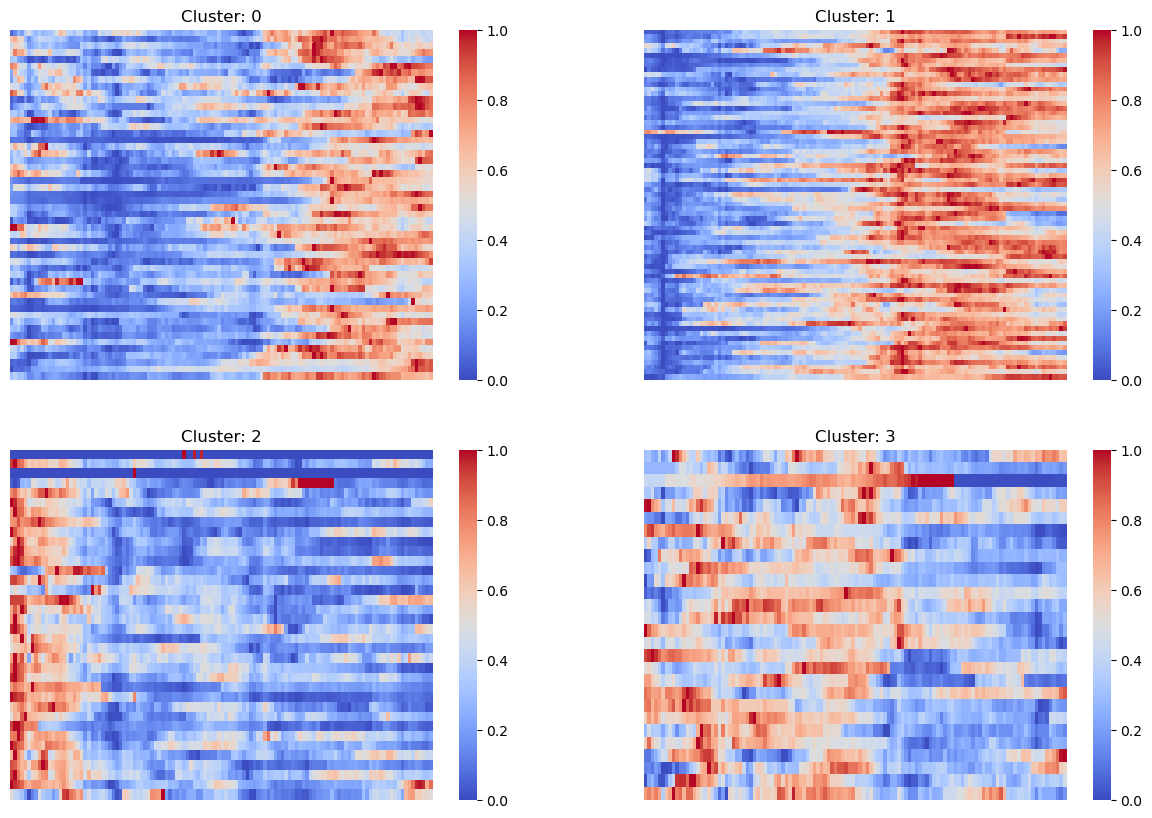

In [71]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=2, ncols=2)
sns.heatmap(cluster_df[cluster_df['cluster'] == 0].iloc[:, :120], xticklabels=False, yticklabels=False, cmap='coolwarm', ax=axs[0,0])
sns.heatmap(cluster_df[cluster_df['cluster'] == 1].iloc[:, :120], xticklabels=False, yticklabels=False, cmap='coolwarm', ax=axs[0,1])
sns.heatmap(cluster_df[cluster_df['cluster'] == 2].iloc[:, :120], xticklabels=False, yticklabels=False, cmap='coolwarm', ax=axs[1,0])
sns.heatmap(cluster_df[cluster_df['cluster'] == 3].iloc[:, :120], xticklabels=False, yticklabels=False, cmap='coolwarm', ax=axs[1,1])
axs[0,0].set_title('Cluster: 0')
axs[0,1].set_title('Cluster: 1')
axs[1,0].set_title('Cluster: 2')
axs[1,1].set_title('Cluster: 3')
plt.show()

In [13]:
# def elbow(X):
#     sse = []

#     for i in range(1,11):
#         km = KMeans(n_clusters=i, algorithm='auto', random_state=42)
#         km.fit(X)
#         sse.append(km.inertia_)

#     plt.plot(range(1,11), sse, marker='o')
#     plt.xlabel('K')
#     plt.ylabel('SSE')
#     plt.show()

# elbow(scaled_df)

In [83]:
from sklearn.manifold import TSNE

transformed = TSNE(n_components=2).fit_transform(cluster_df.iloc[:, :120])
transformed.shape

(189, 2)

In [84]:
tsne_df = pd.concat([pd.DataFrame(transformed), cluster_df['cluster']], axis=1)

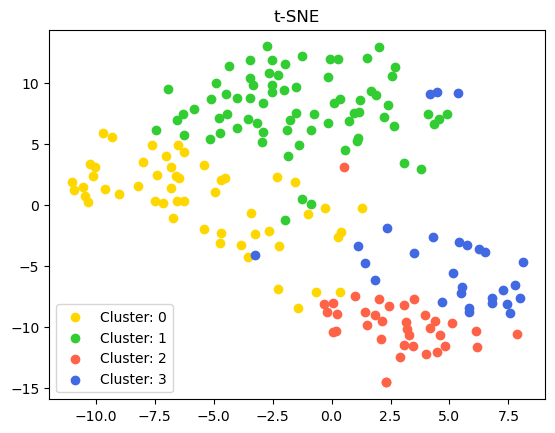

In [86]:
plt.scatter(tsne_df[tsne_df['cluster'] == 0].iloc[:, 0], tsne_df[tsne_df['cluster'] == 0].iloc[:, 1], label='Cluster: 0', c='gold')
plt.scatter(tsne_df[tsne_df['cluster'] == 1].iloc[:, 0], tsne_df[tsne_df['cluster'] == 1].iloc[:, 1], label='Cluster: 1', c='limegreen')
plt.scatter(tsne_df[tsne_df['cluster'] == 2].iloc[:, 0], tsne_df[tsne_df['cluster'] == 2].iloc[:, 1], label='Cluster: 2', c='tomato')
plt.scatter(tsne_df[tsne_df['cluster'] == 3].iloc[:, 0], tsne_df[tsne_df['cluster'] == 3].iloc[:, 1], label='Cluster: 3', c='royalblue')
plt.title('t-SNE')
plt.legend()
plt.show()

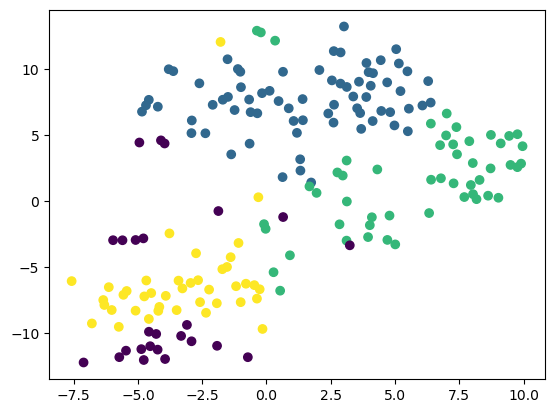

In [35]:
xs = transformed[:,0]
ys = transformed[:,1]
plt.scatter(xs,ys, c=cluster_df['cluster'])  #라벨은 색상으로 분류됨
plt.show()

In [174]:
for c in range(4):
    print(f'===== Cluster: {c} =====')
    print(pd.Series(cluster_df[cluster_df['cluster'] == c]['업종명'].value_counts() / cluster_df['업종명'].value_counts()).sort_values(ascending=False)[:5],'\n')

===== Cluster: 0 =====
비금속광물   0.33
섬유의복    0.33
음식료품    0.22
증권      0.20
기계      0.17
Name: 업종명, dtype: float64 

===== Cluster: 1 =====
전기가스업   1.00
건설업     0.80
서비스업    0.63
기계      0.50
운수창고업   0.33
Name: 업종명, dtype: float64 

===== Cluster: 2 =====
전기전자    0.75
의약품     0.64
운수장비    0.46
운수창고업   0.33
화학      0.25
Name: 업종명, dtype: float64 

===== Cluster: 3 =====
기타제조업         1.00
농업, 임업 및 어업   1.00
보험            1.00
은행            1.00
철강금속          0.86
Name: 업종명, dtype: float64 

